In [34]:
# Import required libraries

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [35]:
# Load datasets
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")

In [36]:
# Exploratory Data Analysis
print(train.info())
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6

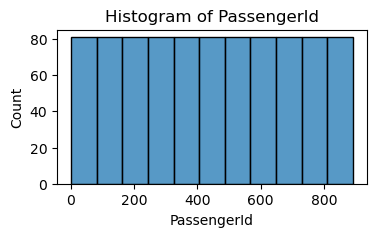

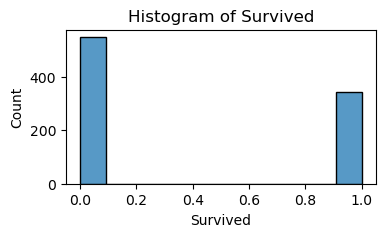

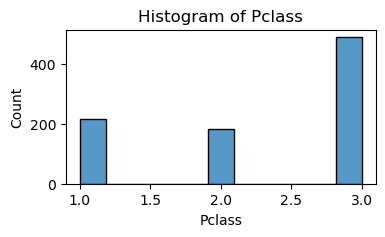

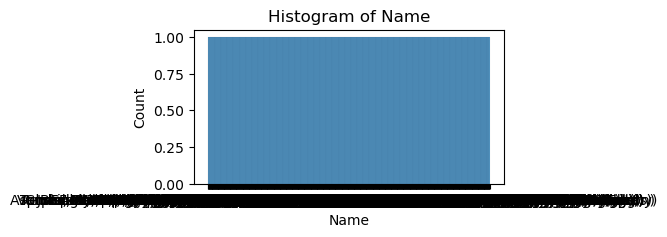

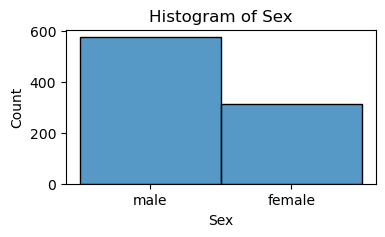

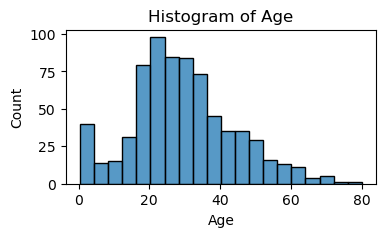

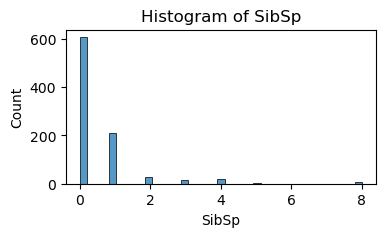

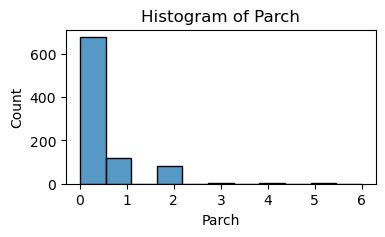

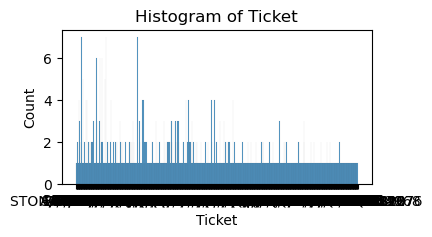

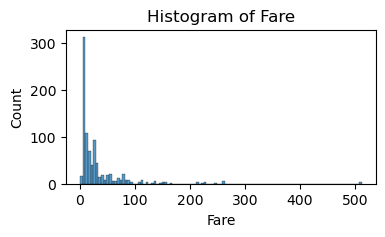

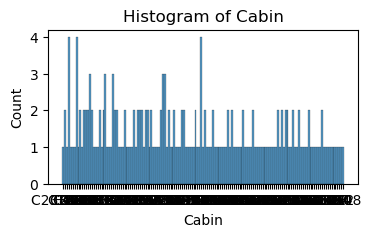

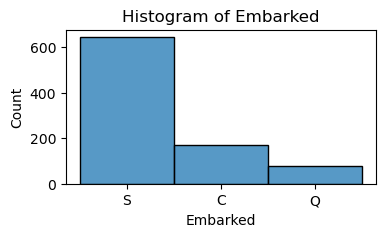

In [37]:
#Histogram

# Visualize distribution of each column using histograms
for col in train.columns:
    plt.figure(figsize=(4, 2))
    sns.histplot(train[col])
    plt.title(f"Histogram of {col}")
    plt.show()

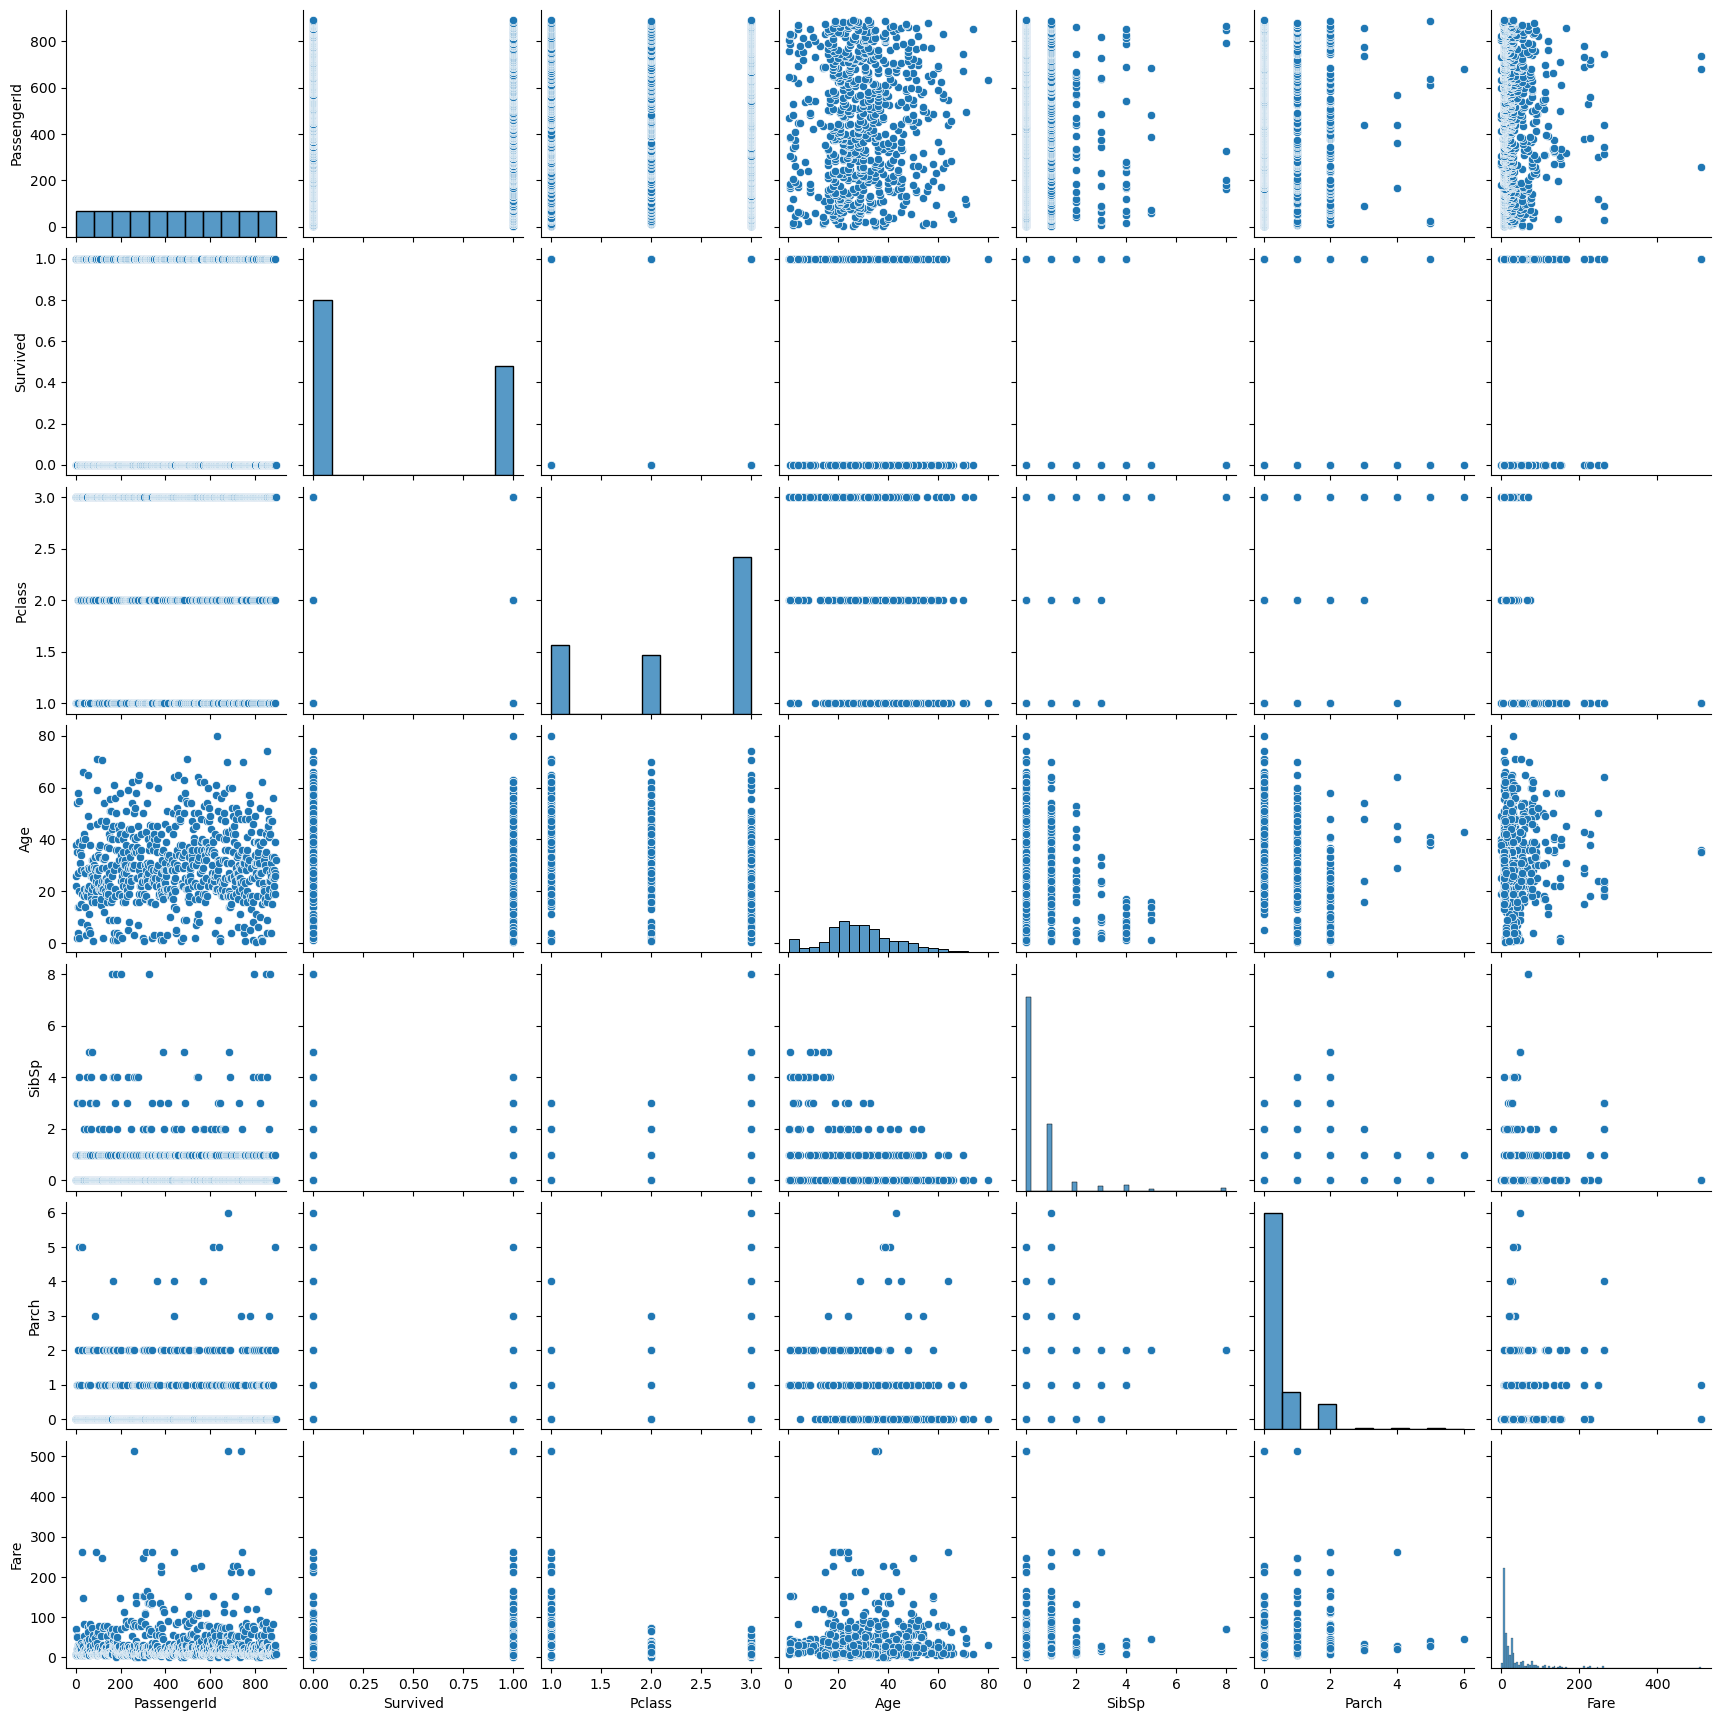

In [38]:
#Pair plots
sns.pairplot(train)
plt.show()

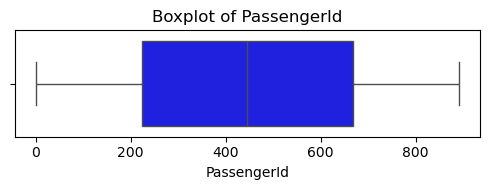

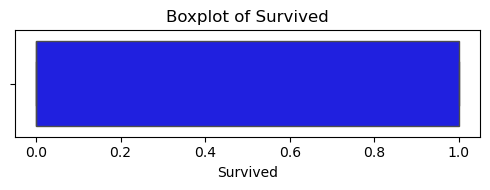

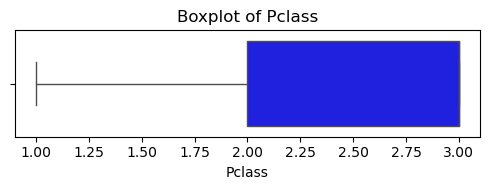

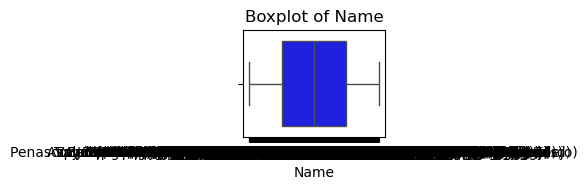

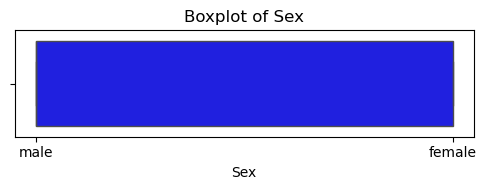

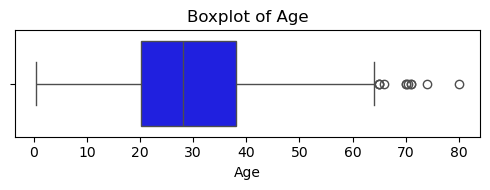

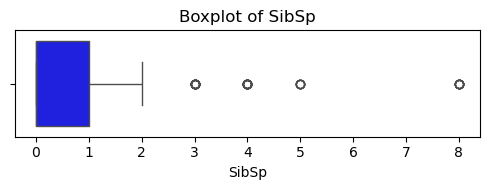

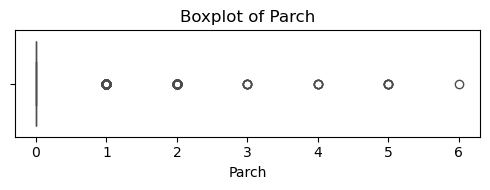

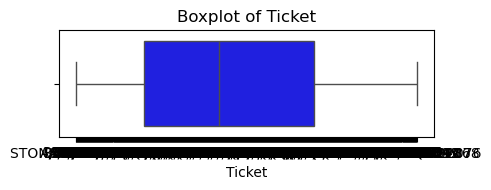

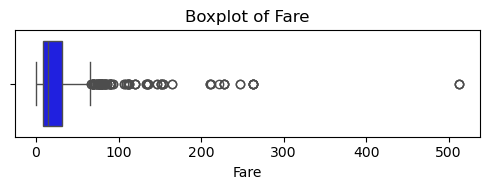

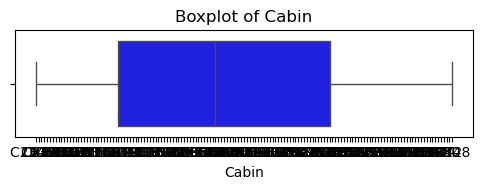

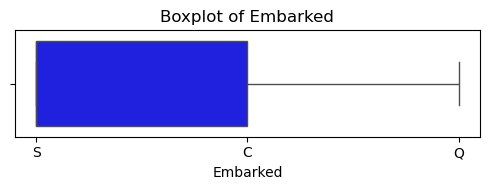

In [39]:
#Boxplot

for col in train.columns:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=train[col], color='blue')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

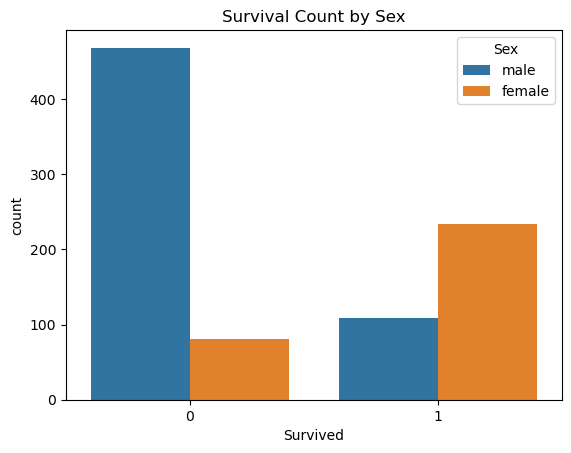

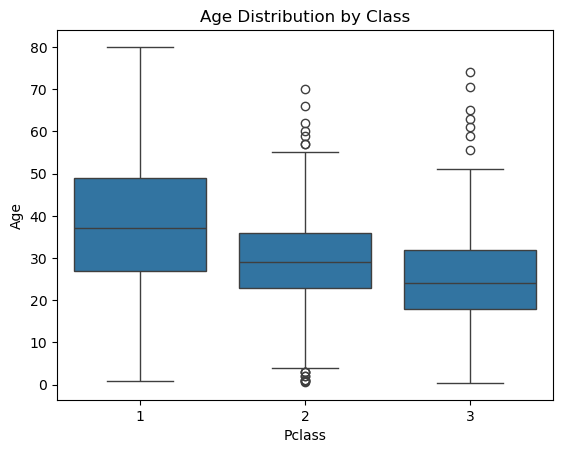

In [40]:
#Barplot

sns.countplot(data=train, x='Survived', hue='Sex')
plt.title("Survival Count by Sex")
plt.show()
sns.boxplot(data=train, x='Pclass', y='Age')
plt.title("Age Distribution by Class")
plt.show()

In [41]:
# Feature Engineering
for df in [train, test]:
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
    df['Title'] = df['Title'].replace({
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Countess': 'Rare', 'Lady': 'Rare', 'Sir': 'Rare',
        'Don': 'Rare', 'Jonkheer': 'Rare', 'Dr': 'Rare',
        'Rev': 'Rare', 'Major': 'Rare', 'Col': 'Rare', 'Capt': 'Rare'
    })

In [42]:
# Impute missing Age using Title median
title_age_map = train.groupby('Title')['Age'].median().to_dict()
for df in [train, test]:
    df['Age'] = df.apply(lambda row: title_age_map.get(row['Title'], train['Age'].median()) if pd.isnull(row['Age']) else row['Age'], axis=1)
    df['Embarked'].fillna('S', inplace=True)
    df['Fare'].fillna(train['Fare'].median(), inplace=True)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['HasCabin'] = df['Cabin'].notnull().astype(int)

In [43]:
# Drop irrelevant features
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train.drop(columns=drop_cols, inplace=True)
test_ids = test['PassengerId']
test.drop(columns=drop_cols, inplace=True)

In [44]:
# Encode categorical features
for df in [train, test]:
    df['Sex'] = (df['Sex'] == 'female').astype(int)
train = pd.get_dummies(train, columns=['Embarked', 'Title'], drop_first=True).astype(int)

In [50]:
test = pd.get_dummies(test, columns=['Embarked', 'Title'], drop_first=True).astype(int)

In [51]:
# Ensure train and test have same dummy columns
test = pd.get_dummies(test)
train, test = train.align(test, join='left', axis=1, fill_value=0)

In [45]:
# Split features and target
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [49]:
# XGBoost Model
xgb_params = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1]
}
xgb_clf = XGBClassifier( eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb_clf, xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
y_pred_xgb = xgb_grid.predict(X_val)
print("\nXGBoost Classification Report")
print(classification_report(y_val, y_pred_xgb))


XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       110
           1       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



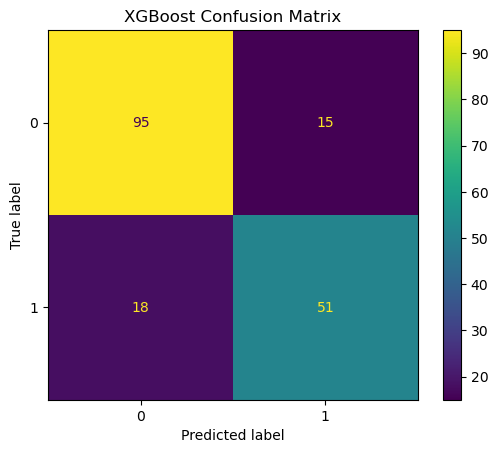

In [60]:
#Confusion Matrix of XGBoost Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_grid, X_val, y_val)
plt.title("XGBoost Confusion Matrix")
plt.show()



In [52]:
# LightGBM Model
lgb_params = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1]
}
lgb_clf = LGBMClassifier(random_state=42)
lgb_grid = GridSearchCV(lgb_clf, lgb_params, cv=3, scoring='accuracy')
lgb_grid.fit(X_train, y_train)
y_pred_lgb = lgb_grid.predict(X_val)
print("\nLightGBM Classification Report")
print(classification_report(y_val, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 182, number of negative: 292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383966 -> initscore=-0.472747
[LightGBM] [Info] Start training from score -0.472747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [53]:
print(classification_report(y_val, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



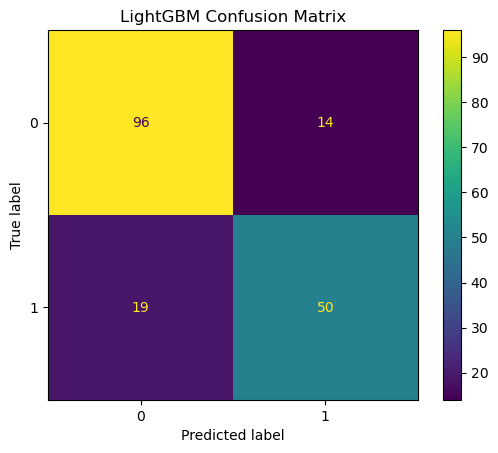

In [61]:
ConfusionMatrixDisplay.from_estimator(lgb_grid, X_val, y_val)
plt.title("LightGBM Confusion Matrix")
plt.show()

In [57]:
# Final predictions on test data (optional)
xgb_test_pred = xgb_grid.predict(test)
lgb_test_pred = lgb_grid.predict(test)

In [56]:
test.drop(columns=['Survived'],inplace = True)

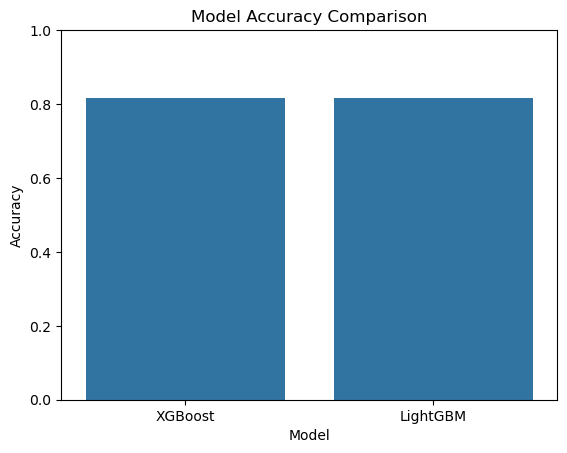

In [58]:
# Visual comparison of model performance
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'Accuracy': [xgb_grid.score(X_val, y_val), lgb_grid.score(X_val, y_val)]
})
sns.barplot(data=metrics_df, x='Model', y='Accuracy')
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()

In [62]:
#Summary

#Both models yielded effective classifiers for Titanic survival.
#XGBoost and LightGBM achieved comparable accuracy (around 82–85%) on the validation split, with XGBoost giving a slightly higher F1-score on average. 
#The confusion matrices indicated that most misclassifications were false negatives (survivors predicted as non-survivors), a common issue in this imbalanced task.

#For the Titanic dataset (small size), both models work well.
#For larger or real-time scenarios, LightGBM’s speed advantage is significant. 
#XGBoost’s stability and regularization features make it a strong default choice.
#Ultimately, careful cross-validation and tuning are needed for both. The comparative analysis shows that algorithm choice can be dataset-dependent, and it is good practice to try both gradient-boosting implementations in a project like this.